Q. diabetes.csv 데이터세트를 이용해 다음사항을 수행하여 당뇨병 여부를 판단하는 머신러닝 예측 모델을 작성하고 평가하세요.
- zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']는 0값을 평균값으로 대체
- 정확도, 정밀도, 재현율, F1 Score, ROC_AUC Score를 포함하는 평가지표 사용자 함수 작성
- 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화
- 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 임계값 산출
- 산출된 임계값을 적용한 평가

※ 피처 정보  
'Pregnancies'(임신 횟수), 'Glucose'(포도당 부하 검사 수치), 'BloodPressure'(혈압),
'SkinThickness'(팔 삼두근 뒤쪽의 피하지방 측정값, 'Insulin'(혈청 인슈린),
'BMI'(체질량 지수), 'DiabetesPedigreeFunction'(당뇨 내력 가중치 값), 'Age', 'Outcome'

## 피마 인디언 당뇨병 예측
* 데이터 세트는 북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터임.
* 고립된 지역에서 인디언 고유의 혈통이 지속돼 왔지만 20세기 후반에 들어서면서 서구화된 식습관으로 많은 당뇨 환자 발생

In [3]:
# 768개의 데이터중에서 Negative 값 0이 500개, Positive값 1이 268개임

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('/content/drive/MyDrive/kdt_240424/m5_머신러닝/dataset/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Outcome
0    500
1    268
Name: count, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [2]:
diabetes_data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [3]:
diabetes_data.info()

# Null 값은 없으며 피처의 타입은 모두 숫자형임.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
# 평가 지표 함수
def get_clf_eval(y_test=None, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬:\n',confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [5]:
# 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화
def precision_recall_curve_plot(y_test=None, pred_proba_c1=None):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)

    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는
    # 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))

    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()


In [6]:
# 예측 모델 생성
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출.
# 맨 끝이 Outcome 컬럼으로 레이블 값임. 컬럼 위치 -1을 이용해 추출

X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify=y)
# stratify는 훈련/테스트 데이터들이 원래의 input dataset의 클래스의 비율과 같은 비율을 가지도록 할 것인지 지정한다.
# 예를 들어 0,1의 클래스가 input dataset에 20:80 비율로 있었다면 훈련 데이터와 테스트 데이터 역시 각각의 클래스가 같은 비율로 있도록 지정

# 로지스틱 회귀로 학습,예측 및 평가 수행.
lr_clf = LogisticRegression(max_iter=500,solver='lbfgs',random_state=42)
lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]
get_clf_eval(y_test , pred, pred_proba)

오차 행렬:
 [[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,    F1: 0.6804, AUC:0.8072


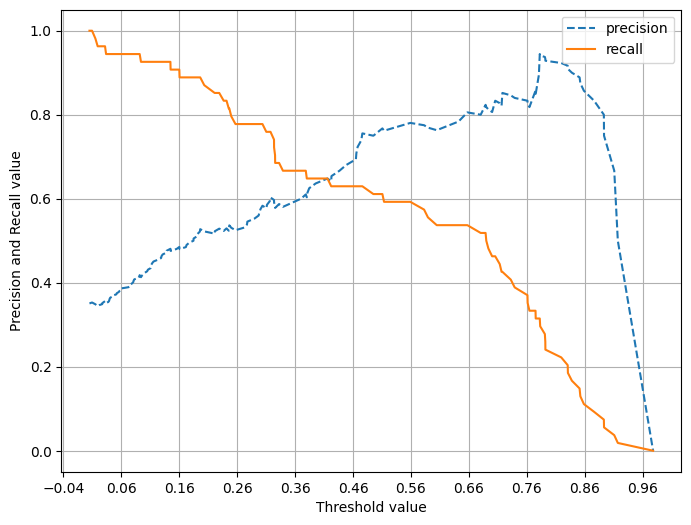

In [7]:
precision_recall_curve_plot(y_test, pred_proba)

# 임곗값을 0.42로 낮추면 정밀도와 재현율이 어느 정도 균형을 맞출 것 같으나
# 모두 0.7이 안되는 낮은 수치를 보임

In [8]:
diabetes_data.describe()

# min() 값이 0으로 돼 있는 피처가 상당히 많으며  예를 들어 Glucose 피처는
# 포도당 수치인데 min 값이 0인 것은 문제가 있음

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [9]:
diabetes_data[diabetes_data.Glucose==0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


<Axes: xlabel='Glucose', ylabel='Count'>

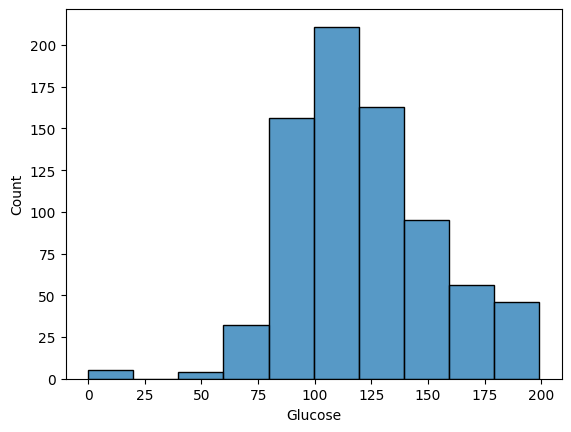

In [10]:
import seaborn as sns

sns.histplot(diabetes_data['Glucose'], bins=10)

In [11]:
# 0값을 검사할 피처명 리스트 객체 설정
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# Pregnancies는 출산 횟수를 의미하므로 제외

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복 하면서 데이터 값이 0 인 데이터 건수 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    total_count = diabetes_data[feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

# SkinThickness 와 Insulin의 0 값은 상당히 많기 때문에 일괄 삭제가 어려우며 평균값으로 대체

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


In [12]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0, diabetes_data[zero_features].mean())

In [13]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,26.606479,118.660163,32.450805,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,9.631241,93.080358,6.875374,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,20.536458,79.799479,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [14]:
# 로지스틱 회귀의 경우 일반적으로 숫자 데이터에 스케일링을 하는 것이 좋으며
# 다시 학습/테스트 데이터 세트로 나누고 로지스틱 회귀를 적용, 성능 평가 지표를 확인

X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler( )
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행.
lr_clf = LogisticRegression()
lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]
get_clf_eval(y_test , pred, pred_proba)

# 데이터 변환과 스케일링을 통해 성능 수치가 일정 수준 개선되었으나 재현율 수치는 개선 필요

오차 행렬:
 [[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,    F1: 0.6804, AUC:0.8433


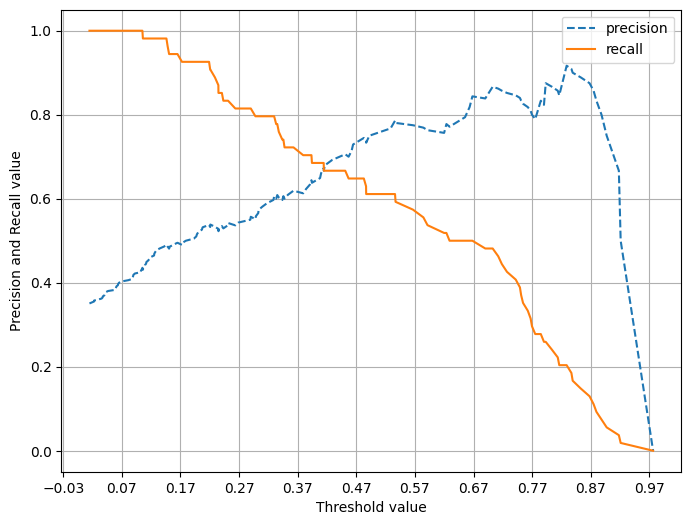

In [17]:
precision_recall_curve_plot(y_test, pred_proba)
# 임곗값을 0.42로 낮추면 정밀도와 재현율이 어느 정도 균형을 맞출 것 같으나
# 모두 0.7이 안되는 낮은 수치를 보임

In [18]:
len(pred_proba)

154

In [15]:
# 임계값에 따른 평가 수치 출력 함수
from sklearn.preprocessing import Binarizer
pred_proba_c1 = pred_proba.reshape(-1,1)
def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds 리스트 객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict, pred_proba_c1)
        print()

In [16]:
# 임곗값은 0.3에서 0.5까지 변화시키면서 평가 지표 확인
thresholds = [0.3 , 0.33 ,0.36,0.39, 0.42 , 0.45 ,0.48, 0.50]
get_eval_by_threshold(y_test, pred_proba_c1, thresholds )

임곗값: 0.3
오차 행렬:
 [[67 33]
 [11 43]]
정확도: 0.7143, 정밀도: 0.5658, 재현율: 0.7963,    F1: 0.6615, AUC:0.8433

임곗값: 0.33
오차 행렬:
 [[72 28]
 [12 42]]
정확도: 0.7403, 정밀도: 0.6000, 재현율: 0.7778,    F1: 0.6774, AUC:0.8433

임곗값: 0.36
오차 행렬:
 [[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222,    F1: 0.6667, AUC:0.8433

임곗값: 0.39
오차 행렬:
 [[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037,    F1: 0.6667, AUC:0.8433

임곗값: 0.42
오차 행렬:
 [[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667,    F1: 0.6792, AUC:0.8433

임곗값: 0.45
오차 행렬:
 [[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667,    F1: 0.6857, AUC:0.8433

임곗값: 0.48
오차 행렬:
 [[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,    F1: 0.6931, AUC:0.8433

임곗값: 0.5
오차 행렬:
 [[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,    F1: 0.6804, AUC:0.8433



In [21]:
# 재현율을 약각 올리면서 전체적인 성능 평가 지표를 올리는 임곗값 : 0.48

get_eval_by_threshold(y_test, pred_proba_c1, [0.33,0.48, 0.5] )

임곗값: 0.33
오차 행렬:
 [[72 28]
 [12 42]]
정확도: 0.7403, 정밀도: 0.6000, 재현율: 0.7778,    F1: 0.6774, AUC:0.8433

임곗값: 0.48
오차 행렬:
 [[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,    F1: 0.6931, AUC:0.8433

임곗값: 0.5
오차 행렬:
 [[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,    F1: 0.6804, AUC:0.8433



임계값을 변경하면 재현율(Recall)과 정밀도(Precision)가 변화하지만 AUC(Area Under the Curve)는 동일하게 유지되는 이유는 AUC가 임계값의 변화에 무관한 평가 지표이기 때문이다.

- 재현율과 정밀도의 변화: 임계값을 변경하면 분류기가 어떤 예측을 '긍정' 또는 '부정'으로 분류할지 기준이 바뀌며 이에 따라 True Positive, False Positive, True Negative, False Negative의 수가 변하게 되며 이는 재현율과 정밀도를 직접적으로 영향을 미친다.

- AUC의 불변성: AUC는 ROC(Receiver Operating Characteristic) 곡선 아래의 면적을 의미. ROC 곡선은 모든 가능한 임계값에 대해 True Positive Rate(TPR, 재현율)과 False Positive Rate(FPR)을 플롯한 것이다. AUC는 이 곡선 아래의 전체 면적을 측정하는 것이므로, 특정 임계값에서의 성능 변화보다는 분류기의 전반적인 성능을 평가. 이 때문에 임계값이 변해도 AUC 값은 동일하게 유지된다.

- 결론적으로, 재현율과 정밀도는 특정 임계값에서의 성능을 나타내는 반면, AUC는 분류기의 전체적인 성능을 종합적으로 평가하는 지표로, 임계값의 변화에 영향을 받지 않는다.